In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
book_videopath = f"assignment_2_materials/book.mov"
ar_video_path = f"assignment_2_materials/ar_source.mov"
cv_coverpath = f"assignment_2_materials/cv_cover.jpg"

In [55]:
# Load and convert the CV book cover image
cv_cover = cv2.imread(cv_coverpath)
cv_cover = cv2.cvtColor(cv_cover, cv2.COLOR_BGR2RGB)

#### Get first frames

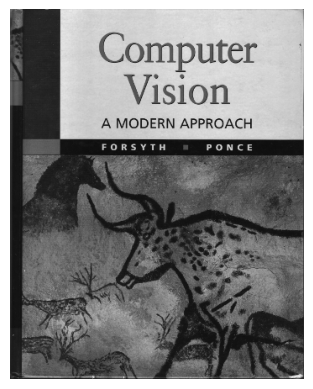

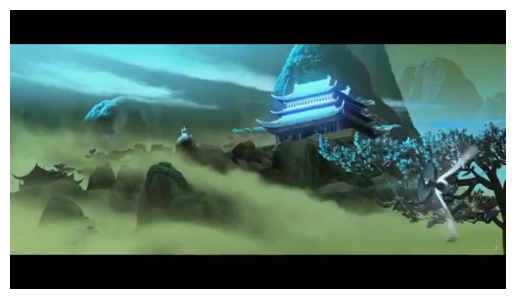

In [56]:
# Load and convert the first video frame
ar_cap = cv2.VideoCapture(ar_video_path)
ok, ar_frame = ar_cap.read()
plt.imshow(cv_cover)
plt.axis("off")
plt.show()
if ok:
  frame = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB)
  plt.imshow(ar_frame)
  plt.axis("off")
  plt.show()
else:
    print("Failed in reading video frame")

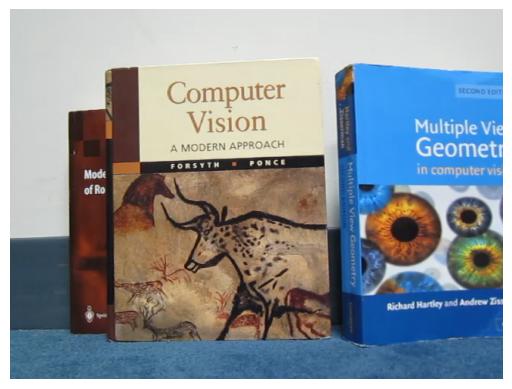

In [57]:
book_cap = cv2.VideoCapture(book_videopath)
ok, book_frame = book_cap.read()
if ok:
  book_frame = cv2.cvtColor(book_frame, cv2.COLOR_BGR2RGB)
  plt.imshow(book_frame)
  plt.axis("off")
  plt.show()
else:
    print("Failed in reading video frame")



### find descriptors

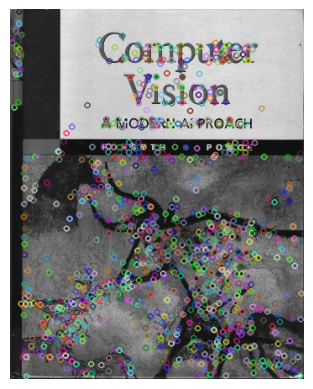

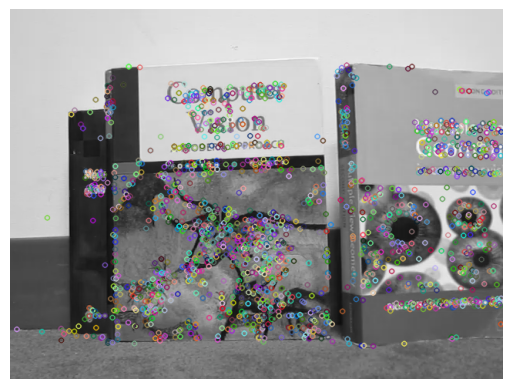

In [58]:
graycv_cover = cv2.cvtColor(cv_cover, cv2.COLOR_BGR2GRAY)
graybook_frame = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)


sift=cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(graycv_cover, None)
keypoints_book, descriptors_book = sift.detectAndCompute(graybook_frame, None)


keypoints_img=cv2.drawKeypoints(graycv_cover, keypoints, None)
keypoints_book_img=cv2.drawKeypoints(graybook_frame, keypoints_book, None)

plt.imshow(keypoints_img)
plt.axis("off")
plt.show()

plt.imshow(keypoints_book_img)
plt.axis("off")
plt.show()


### get matches

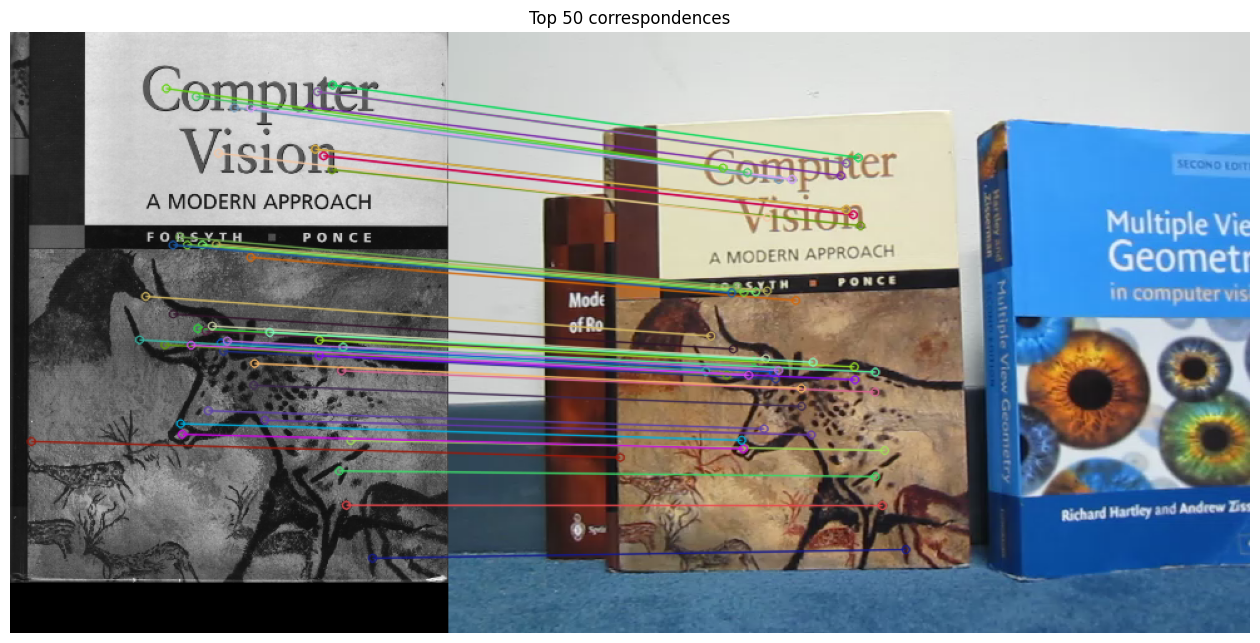

In [59]:
graycv_cover = cv2.cvtColor(cv_cover, cv2.COLOR_RGB2GRAY)
graybook_frame = cv2.cvtColor(book_frame, cv2.COLOR_RGB2GRAY)
#initialize the SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(graycv_cover, None)
kp2, des2 = sift.detectAndCompute(graybook_frame, None)
max_matches = 50
ratio_threshold = 0.65
#brute force matcher with L2 norm
bf = cv2.BFMatcher(cv2.NORM_L2)
#KNN matching
knn = bf.knnMatch(des1, des2, k=2)
good_matches = []
for m, n in knn:
    #m is the closest match and n second
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)
#sort matches by distance and limit to the top 50
matches = sorted(good_matches, key=lambda x: x.distance)[:max_matches]
#draw the top 50 matches on a combined image
match_img = cv2.drawMatches(cv_cover, kp1, book_frame, kp2, matches, None, flags=2)
# Display the resulting image with drawn matches
plt.figure(figsize=(16, 8))
plt.imshow(match_img)
plt.title("Top 50 correspondences")
plt.axis("off")
plt.show()


In [60]:
def compute_homography(sources,destinations):
    assert sources.shape==destinations.shape
    n = sources.shape[0]
    if n<4:
        raise ValueError("Need at least 4 correspondences")

    #build matrix A for the system Ax = b
    #each correspondence gives us 2 equations
    A=[]

    for i in range(n):
        x, y=sources[i]
        x_, y_=destinations[i]

        A.append([-x, -y, -1, 0, 0, 0, x_*x, x_*y, x_])
        A.append([0, 0, 0, -x, -y, -1, y_*x, y_*y, y_])

    A=np.array(A)

    # Solve using SVD: A = U*S*V^T
    U,S,Vt=np.linalg.svd(A)
    h=Vt[-1, :]

    # Reshape into 3x3 matrix
    H=h.reshape(3, 3)
    H=H / H[2, 2]

    return H


# Extract matched points from your existing matches
sources=np.float32([kp1[m.queryIdx].pt for m in matches])  #points from cv_cover
destinations=np.float32([kp2[m.trainIdx].pt for m in matches])  #points from book_frame

# Compute homography using our function
H=compute_homography(sources,destinations)

print("Homography Matrix:")
print(H)

Homography Matrix:
[[ 7.71581740e-01  2.55525811e-03  1.19636279e+02]
 [-5.22764778e-02  7.77461981e-01  7.77622602e+01]
 [-9.49731699e-05 -7.55763948e-05  1.00000000e+00]]


In [61]:
def apply_homography(points, H):

    # Convert to homogeneous coordinates (add column of ones)
    n=points.shape[0]
    homopoints=np.column_stack([points, np.ones(n)])

    # Apply homography: p' = H * p
    homotrans=(H @ homopoints.T).T

    # Convert back to non-homogeneous coordinates (divide by last coordinate)
    homotrans=homotrans[:, :2]/homotrans[:, 2:3]

    return homotrans


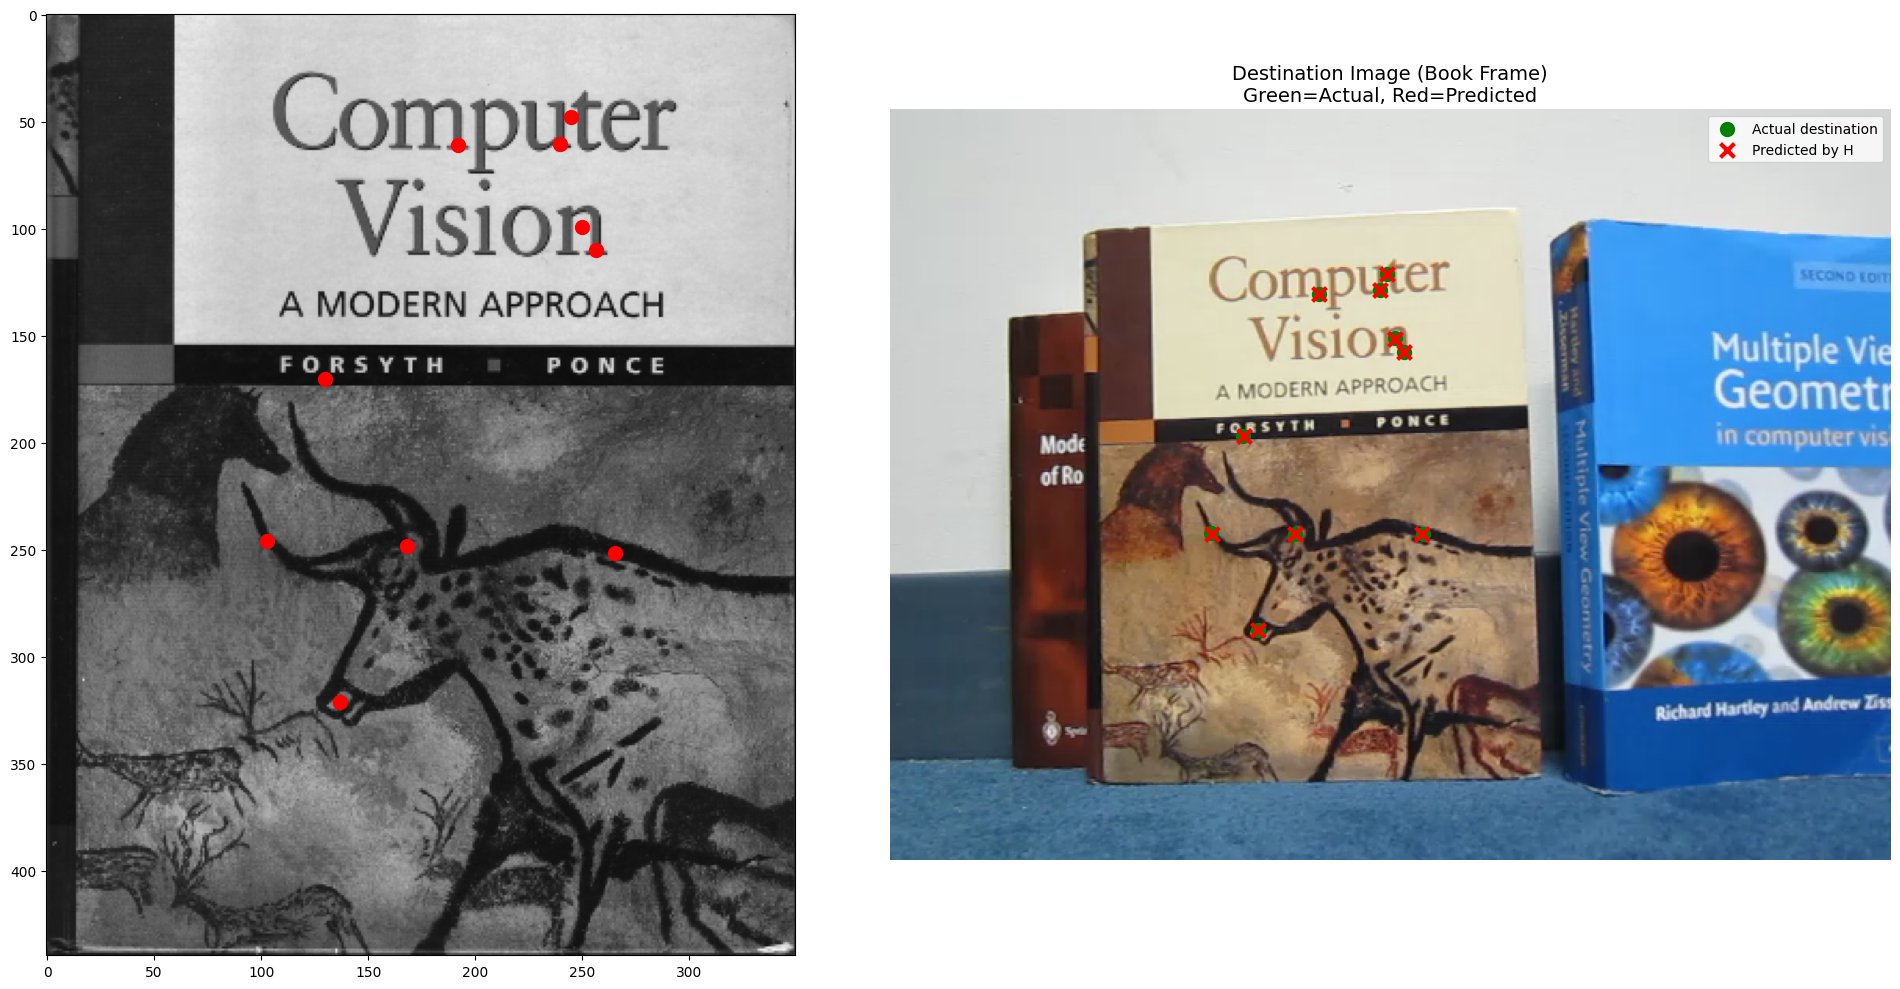

In [62]:
# Test the homography by mapping a few points
num_test=10
test_indices=np.random.choice(len(matches), num_test, replace=False)

test_sources=sources[test_indices]
test_destinations=destinations[test_indices]

# Apply our homography
predicted_pts=apply_homography(test_sources,H)

# Visualize the verification
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(20, 10))

# Show source image with test points
ax1.imshow(cv_cover)
ax1.scatter(test_sources[:, 0], test_sources[:, 1], c='red', s=100, marker='o', label='Source points')


# Show destination image with actual and predicted points
ax2.imshow(book_frame)
ax2.scatter(test_destinations[:, 0], test_destinations[:, 1], c='green', s=100, marker='o', label='Actual destination')
ax2.scatter(predicted_pts[:, 0], predicted_pts[:, 1], c='red', s=100, marker='x', linewidths=3, label='Predicted by H')


ax2.set_title('Destination Image (Book Frame)\nGreen=Actual, Red=Predicted', fontsize=14)
ax2.legend()
ax2.axis('off')

plt.tight_layout()
plt.show()


Book Corners in Video Frame:
[[119.63627932  77.76226015]
 [402.25117794  61.55815357]
 [417.7465509  429.2960717 ]
 [124.90204224 433.44905896]]


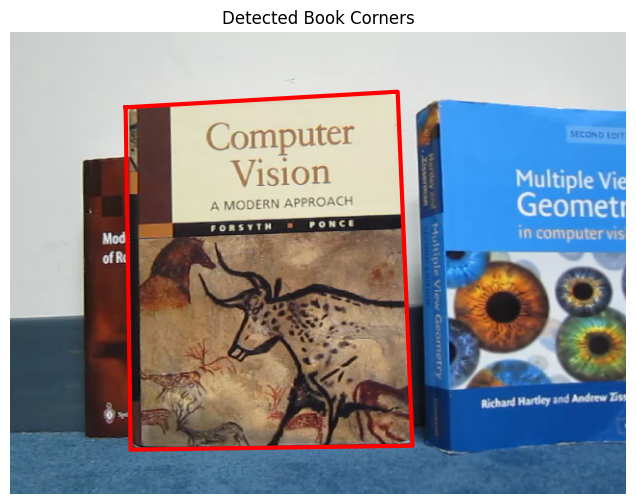

In [63]:
#section 1.3
#dimensions of the cv_cover image
height,width=cv_cover.shape[:2]
book_corners_cover=np.array([
    [0, 0],              #top left
    [width-1, 0],      #top right
    [width-1, height-1],  #bottom right
    [0, height-1]       #bottom left
], dtype=np.float32)

# Map these corners to the book video frame using the homography
book_corners=apply_homography(book_corners_cover, H)

print("Book Corners in Video Frame:")
print(book_corners)

plt.figure(figsize=(12, 6))
plt.imshow(book_frame)
plt.plot([book_corners[0,0], book_corners[1,0], book_corners[2,0],
          book_corners[3,0], book_corners[0,0]],
         [book_corners[0,1], book_corners[1,1], book_corners[2,1],
          book_corners[3,1], book_corners[0,1]],
         'r-', linewidth=3)
plt.title('Detected Book Corners')
plt.axis('off')
plt.show()


### section 1.4 crop the ar video to the book cover 


In [ ]:
def crop(src,des):
    des_h, des_w = des.shape[:2]
    src_h, src_w = src.shape[:2]
    target_ratio = des_w / des_h
    frame_ratio = src_w / src_h
    if frame_ratio > target_ratio:
        new_w = int(src_h * target_ratio)
        x1 = (src_w - new_w) // 2
        cropped = src[:, x1:x1 + new_w]
    else:
        new_h = int(src_w / target_ratio)
        y1 = (src_h - new_h) // 2
        cropped = src[y1:y1 + new_h, :]
    return cropped


In [65]:
# section 1.4 crop the ar video to the book cover 
cap = cv2.VideoCapture("assignment_2_materials/ar_source.mov")
writer = None
while True:
    ok, frame = cap.read()
    if not ok:
        break
    cropped=crop(frame, cv_cover)
    cropped = cv2.resize(cropped, (cv_cover.shape[1], cv_cover.shape[0]))
    if writer is None:
        h, w = cropped.shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter("output/cropped_output.mp4", fourcc, cap.get(cv2.CAP_PROP_FPS), (w, h))
    writer.write(cropped)
cap.release()
writer.release()

In [66]:
def overlay(bg, fg, corners):
    mask = np.zeros(bg.shape[:2], dtype=np.uint8)
    poly = corners.astype(np.int32).reshape((-1, 1, 2))
    cv2.fillConvexPoly(mask, poly, 255)
    mask_inv = cv2.bitwise_not(mask)
    bg_bg = cv2.bitwise_and(bg, bg, mask=mask_inv)
    fg_fg = cv2.bitwise_and(fg, fg, mask=mask)
    final_frame = cv2.add(bg_bg, fg_fg)
    return final_frame

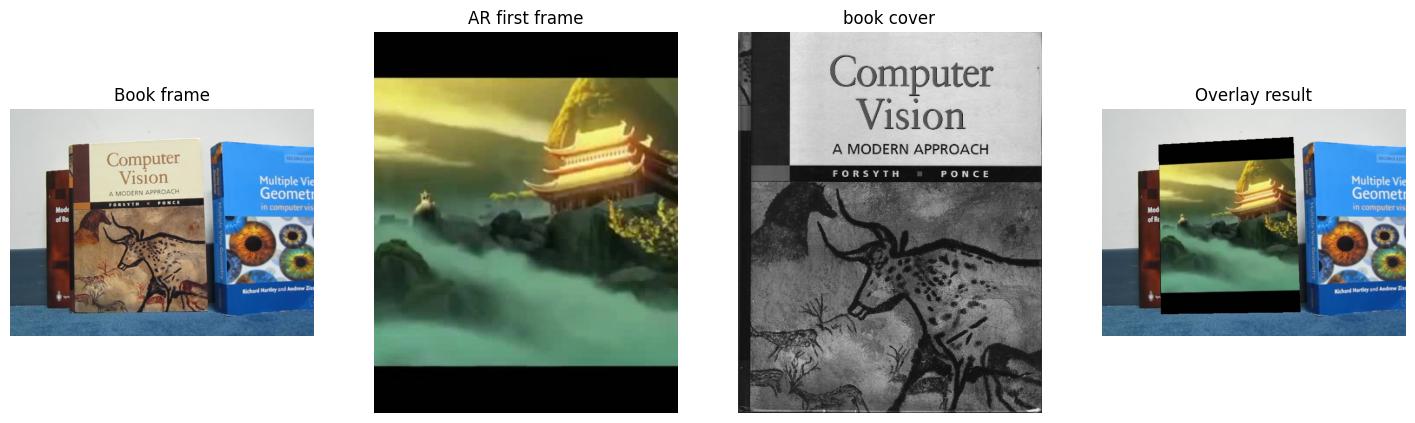

In [ ]:
# section 1.5 Overlay the first frame of the two videos
# Uses the homography H from the first frame to place the first AR frame onto the book
ar_cropped_cap = cv2.VideoCapture("output/cropped_output.mp4")
book_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

ok_book, book_frame = book_cap.read()
ok_ar, ar_cropped_frame= ar_cropped_cap.read()
height, width = cv_cover.shape[0], cv_cover.shape[1]

if ok_book and ok_ar:
    book_bg = cv2.cvtColor(book_frame, cv2.COLOR_BGR2RGB)
    ar_fg = cv2.cvtColor(ar_cropped_frame, cv2.COLOR_BGR2RGB)
    ar_fg = cv2.resize(ar_fg, (width, height))
    warped_cover = cv2.warpPerspective(ar_fg, H, (book_bg.shape[1], book_bg.shape[0]))
    transformed_corners = apply_homography(book_corners_cover, H)
    result_frame = overlay(book_bg, warped_cover, transformed_corners)
    plt.figure(figsize=(18,6))
    plt.subplot(1,4,1); plt.imshow(book_bg); plt.title('Book frame'); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(ar_fg); plt.title('AR first frame'); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(cv_cover); plt.title('book cover'); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(result_frame); plt.title('Overlay result'); plt.axis('off')
    plt.show()
else:
    if not ok_book:
        print('Failed reading first book frame')
    if not ok_ar:
        print('Failed reading first AR (cropped) frame')



In [68]:
def get_matches_L2_KNN(img1, img2,max_matches=50, ratio_threshold=0.65):
#initialize the SIFT detector
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    #brute force matcher with L2 norm
    bf = cv2.BFMatcher(cv2.NORM_L2)

    #KNN matching
    knn = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in knn:
        #m is the closest match and n second
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    #sort matches by distance and limit to the top 50
    matches = sorted(good_matches, key=lambda x: x.distance)[:max_matches]
    return matches, kp1, kp2

In [72]:
fps = book_cap.get(cv2.CAP_PROP_FPS)
output_video_path = "output/matches_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None

In [ ]:

book_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
n_frames = int(book_cap.get(cv2.CAP_PROP_FRAME_COUNT))
homographies=[]

# add tqdm progress bar
for frame_idx in tqdm(range(n_frames), desc="Processing frames"):
    ok, book_frame = book_cap.read()
    if not ok:
        print(f"Failed to read frame {frame_idx}")
        break
    book_frame_rgb = cv2.cvtColor(book_frame, cv2.COLOR_BGR2RGB)
    graybook_frame = cv2.cvtColor(book_frame_rgb, cv2.COLOR_RGB2GRAY)

    matches, kp1, kp2 = get_matches_L2_KNN(cv_cover, book_frame_rgb)
    match_img = cv2.drawMatches(cv_cover, kp1, book_frame_rgb, kp2, matches, None, flags=2)

    sources=np.float32([kp1[m.queryIdx].pt for m in matches])  #points from cv_cover
    destinations=np.float32([kp2[m.trainIdx].pt for m in matches])  #points from book_frame

    if len(sources) >= 4:
        H, mask = cv2.findHomography(sources, destinations, cv2.RANSAC, 5.0)
    else:
        H = homographies[-1] if homographies else np.eye(3)
    homographies.append(H)

    if out is None:
        height, width = match_img.shape[:2]
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    match_img_bgr = cv2.cvtColor(match_img, cv2.COLOR_RGB2BGR)
    out.write(match_img_bgr)


Total number of frames: 641.0


Processing frames: 100%|██████████| 641/641 [01:18<00:00,  8.21it/s]


In [73]:
if out is not None:
    out.release()

In [71]:
# Reset the book video to the start and open the cropped AR video
book_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ar_cropped_cap = cv2.VideoCapture("output/cropped_output.mp4")
fps = book_cap.get(cv2.CAP_PROP_FPS)
output_video_path = "output/ar_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
height, width = cv_cover.shape[0], cv_cover.shape[1]

len_book=int(book_cap.get(cv2.CAP_PROP_FRAME_COUNT))
len_ar=int(ar_cropped_cap.get(cv2.CAP_PROP_FRAME_COUNT))

ok, first_book_frame = book_cap.read()
if not ok:
    print("Failed in reading first book frame")
else:
    final_out = cv2.VideoWriter(output_video_path, fourcc, fps, (first_book_frame.shape[1], first_book_frame.shape[0]))
    book_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

for i in tqdm(range(min(len_ar,len_book)), desc="Processing frames"):

    H=homographies[i]
    
    ok_book, book_frame = book_cap.read()
    ok_ar, ar_cropped_frame = ar_cropped_cap.read()
    book_frame_rgb = cv2.cvtColor(book_frame, cv2.COLOR_BGR2RGB)
    graybook_frame = cv2.cvtColor(book_frame_rgb, cv2.COLOR_RGB2GRAY)
    grayar_frame = cv2.cvtColor(ar_cropped_frame, cv2.COLOR_BGR2RGB)
    ar_cropped_frame = cv2.resize(grayar_frame, (width, height))
    warped_cover = cv2.warpPerspective(ar_cropped_frame, H, (book_frame_rgb.shape[1], book_frame_rgb.shape[0]))
    transformed_corners = apply_homography(book_corners_cover, H)
    final_frame = overlay(book_frame_rgb, warped_cover, transformed_corners)
    text = f"Frame: {i}"
    cv2.putText(final_frame, text, (40, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3, cv2.LINE_AA)

    # Write the frame to the output video
    final_out.write(cv2.cvtColor(final_frame, cv2.COLOR_RGB2BGR))    
ar_cropped_cap.release()
final_out.release()
print(f"Video written to {output_video_path}")


Processing frames: 100%|██████████| 511/511 [00:02<00:00, 221.20it/s]

Video written to output/ar_output.mp4
